In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Load the Training and Testing data, please kindly help to change the "testing.csv" to the testing data file name

In [2]:
import geohash2
df_train = pd.read_csv('training.csv')

#Please kindly help to modify the filename of testing data
df_test = pd.read_csv('testing.csv')

train_Y = df_train['demand']
df_train = df_train.drop(['demand'] , axis=1)

df = pd.concat([df_train, df_test])

In [3]:
train_num = train_Y.shape[0]

### Feature Engineering
* geohash6 -> longitude and latitude
* Use (lon, lat) doing cluster


In [5]:
df['latitude'] = df['geohash6'].apply(lambda x: geohash2.decode(x)[0]).astype('float')
df['longitude'] = df['geohash6'].apply(lambda x: geohash2.decode(x)[1]).astype('float')

#Kmeans lon,lat
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=10).fit(df[['latitude', 'longitude']])
df['cluster_n'] = kmeans.labels_

fig = plt.figure(figsize=(10, 5))
x = np.array(df['longitude'])
y = np.array(df['latitude'])

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'aqua', 'brown', 'darkblue']
#print color
for i,c in enumerate(df['cluster_n'][:500]):
    plt.scatter(x[i], y[i], c=colors[c], alpha=0.5)
plt.show()

<Figure size 1000x500 with 1 Axes>

* use PCA method transform longitude and latitude

In [6]:
from sklearn.decomposition import PCA
test = np.vstack(df[['latitude', 'longitude']].values)
pca = PCA().fit(test)
df['lat_pca0'] = pca.transform(df[['latitude', 'longitude']])[:, 0]
df['lon_pca1'] = pca.transform(df[['latitude', 'longitude']])[:, 1]

* Doing feature engineering on column 'timestamp'
* seperate it to 'weekday' 'hour' 'minute' 'time'
* Doing feature combination of time
* transform time to cycle

In [7]:
# feature engineering of timestamp
df['weekday'] = df['day']%7 + 1
df['hour'] = df['timestamp'].str.split(":", expand=True)[0].astype('int64')
df['minute'] = df['timestamp'].str.split(":", expand=True)[1].astype('int64')
df['time'] = df['hour']+df['minute']/60

# slice to time_grp
df['time_grp'] = pd.cut(df['time'], [0, 3, 6, 9, 12, 15, 18, 21, 24],include_lowest=True)

# weekday x time combination
df['wd_time_multiple'] = df['weekday'] * df['time']
df['wd_time_division'] = df['time']/df['weekday'] 
df['time_cluster'] = df['wd_time_multiple'] * df['cluster_n']

# time cycle
import math
df['day_cycle'] = df['hour']/12 + df['minute']/720
df['day_cycle'] = df['day_cycle'].map(lambda x:math.sin(x*math.pi))

df['week_cycle'] = df['weekday']/3.5 + df['hour']/84
df['week_cycle'] = df['week_cycle'].map(lambda x:math.sin(x*math.pi))

### Tableau Visualization
* please refer to Travel Analysis_Kim.twbx
* use transformed data to discover area and time with high demand

* 'weekday' and 'time_grp' use mean encoder

In [8]:
#weekday and time: mean_encoder
data_train = pd.concat([df[:train_num], train_Y], axis=1)

mean_df = data_train.groupby(['weekday'])['demand'].mean().reset_index()
mean_df.columns = ['weekday', 'weekday_mean']
data = pd.merge(df, mean_df, on='weekday', how='left')
#data 是train+test

mean_df = data_train.groupby(['time_grp'])['demand'].mean().reset_index()
mean_df.columns = ['time_grp', 'time_mean']
data = pd.merge(data, mean_df, on='time_grp', how='left')

data.drop(['timestamp','geohash6','time_grp'], axis=1, inplace=True)
data_train = pd.concat([data[:train_num], train_Y], axis=1)
#data_train = X+Y

In [9]:
data_train.head()

,day,latitude,longitude,cluster_n,lat_pca0,lon_pca1,weekday,hour,minute,time,wd_time_multiple,wd_time_division,time_cluster,day_cycle,week_cycle,weekday_mean,time_mean,demand
0,18,-5.35,90.7,7,-0.066194,-0.004023,5,20,0,20.00,100.00,4.000000,700.00,-0.866025,-0.866025,0.116981,0.047142,0.020072
1,10,-5.41,90.7,2,-0.072030,0.055692,4,14,30,14.50,58.00,3.625000,116.00,-0.608761,-0.826239,0.111587,0.115700,0.024721
2,9,-5.33,90.9,1,0.134803,-0.004474,3,6,15,6.25,18.75,2.083333,18.75,0.997859,0.222521,0.109509,0.124073,0.102821
3,32,-5.35,90.8,0,0.033332,0.005704,5,5,0,5.00,25.00,1.000000,0.00,0.965926,-0.999301,0.116981,0.116421,0.088755
4,15,-5.41,90.7,2,-0.072030,0.055692,2,4,0,4.00,8.00,2.000000,16.00,0.866025,0.930874,0.103763,0.116421,0.074468


### Observe distribution of demand
* only 1% data which demand >0.98 -> drop outlier
* please also refer to tableau file

(array([1112058.,  715477.,  490018.,  353930.,  267454.,  207925.,
         163400.,  130212.,  105369.,   85821.,   71313.,   58997.,
          48963.,   41423.,   35367.,   30047.,   25494.,   22354.,
          19528.,   17276.,   14953.,   13230.,   11885.,   10578.,
           9509.,    8593.,    7684.,    7126.,    6470.,    5976.,
           5576.,    5222.,    4904.,    4478.,    4182.,    3796.,
           3714.,    3549.,    3271.,    3101.,    3006.,    2782.,
           2678.,    2471.,    2372.,    2280.,    2179.,    2031.,
           1950.,   44349.]),
 array([3.09221724e-09, 2.00000030e-02, 4.00000030e-02, 6.00000029e-02,
        8.00000028e-02, 1.00000003e-01, 1.20000003e-01, 1.40000003e-01,
        1.60000003e-01, 1.80000003e-01, 2.00000002e-01, 2.20000002e-01,
        2.40000002e-01, 2.60000002e-01, 2.80000002e-01, 3.00000002e-01,
        3.20000002e-01, 3.40000002e-01, 3.60000002e-01, 3.80000002e-01,
        4.00000002e-01, 4.20000002e-01, 4.40000002e-01, 4.60000002

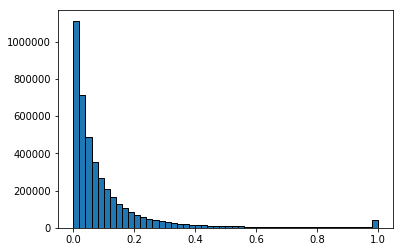

In [12]:
plt.hist(data_train['demand'], edgecolor = 'k', bins = 50)

In [13]:
data1 = data_train[data_train.demand <= 0.95]
train_Y_wo_outlier = data1['demand']
train_wo_outlier_num = train_Y_wo_outlier.shape[0]
data1 = data1.drop(['demand'] , axis=1)

In [14]:
data_train = data1
data_test = data[train_num:]

In [15]:
data_train.shape

(4158986, 17)

In [16]:
data_test.shape

(19, 17)

### Model : Gradient Boosting Regression

In [17]:
# List of features for later use
feature_list = list(data_train.columns)

features = np.array(data_train)
labels = np.array(train_Y_wo_outlier)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [18]:
gdbt_exp = GradientBoostingRegressor(n_estimators= 100, random_state=42)
gdbt_exp.fit(train_features, train_labels);

### Use all features run as baseline

In [20]:
# Make predictions on test data
predictions = gdbt_exp.predict(test_features)

# Performance metrics
rmse_test= (np.sum((predictions - test_labels )**2)/len(test_labels)) ** 0.5

print('Metrics for GDBT Trained on Data')
print('RMSE:', round(rmse_test, 4))

Metrics for GDBT Trained on Data
RMSE: 0.1115


### Feature Selection, use feature importance to sort the importance

In [19]:
importances = list(gdbt_exp.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: lat_pca0             Importance: 0.49
Variable: lon_pca1             Importance: 0.2
Variable: latitude             Importance: 0.09
Variable: time                 Importance: 0.06
Variable: cluster_n            Importance: 0.05
Variable: time_mean            Importance: 0.05
Variable: day_cycle            Importance: 0.02
Variable: weekday              Importance: 0.01
Variable: time_cluster         Importance: 0.01
Variable: week_cycle           Importance: 0.01
Variable: day                  Importance: 0.0
Variable: longitude            Importance: 0.0
Variable: hour                 Importance: 0.0
Variable: minute               Importance: 0.0
Variable: wd_time_multiple     Importance: 0.0
Variable: wd_time_division     Importance: 0.0
Variable: weekday_mean         Importance: 0.0


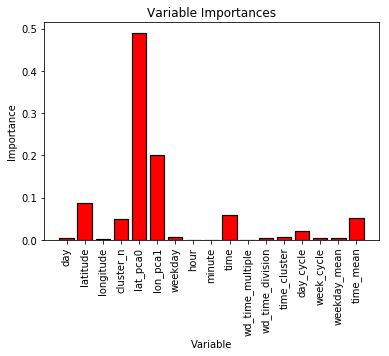

In [21]:
# list of x locations for plotting
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

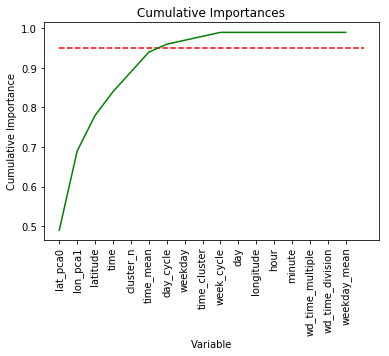

In [22]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [23]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:8]]

important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (3119239, 8)
Important test features shape: (1039747, 8)


### Build the Model of important features only to remain stability and reduce execution time

In [24]:
# Train the model on only the important features
gdbt_exp.fit(important_train_features, train_labels);

In [25]:
# Make predictions on Validate data
predictions = gdbt_exp.predict(important_test_features)

# Performance metrics
important_rmse_test= (np.sum((predictions - test_labels )**2)/len(test_labels)) ** 0.5

print('Metrics for GDBT Trained on important feature')
print('RMSE:', round(important_rmse_test, 4))

Metrics for GDBT Trained on important feature
RMSE: 0.1112


In [26]:
important_feature_names

['lat_pca0',
 'lon_pca1',
 'latitude',
 'time',
 'cluster_n',
 'time_mean',
 'day_cycle',
 'weekday']

### Final: Predict on testing data

In [30]:
# Make predictions on test data

final_test_features = np.array(data_test)
# Create training and testing sets with only the important features
final_test_features = final_test_features[:, important_indices]

final_predictions = gdbt_exp.predict(final_test_features)

## Please kindly help to load demand of testing data

In [ ]:
#Performance metrics
### testing_Y = ... help to load demand of testing data as testing_Y
final_rmse_test= (np.sum((predictions - testing_Y )**2)/len(testing_Y)) ** 0.5

print('Metrics for GDBT on final testing data')
print('RMSE:', round(final_rmse_test, 4))

### Appendix: Propose to use RandomResearchCV to do parameter tuning
>(however, my pc too slow... there is no result of best parameter... only a reference)

In [ ]:
# Extract features and labels
labels = train_Y_wo_outlier
features = data1

# Update feature list for visualizations
feature_list = important_feature_names[:]

features = features[important_feature_names]

In [40]:
# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [65]:
train_features.shape

(3119239, 17)

In [67]:
math.sqrt(3119239/2)

1248.8472684840208

### Examine the Default GDBT to Determine Parameters

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gdbt = GradientBoostingRegressor(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gdbt.get_params())

Parameters currently in use:

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in GDBT
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

learning_rate = [0.1,0.05,0.02]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random gridke
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
              # 'bootstrap': bootstrap}

pprint(random_grid)

{'learning_rate': [0.1, 0.05, 0.02],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gdbt= GradientBoostingRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 

#search across 100 different combinations, and use all available cores
gdbt_random = RandomizedSearchCV(estimator=gdbt, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)
# Fit the random search model
gdbt_random.fit(train_features, train_labels)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_depth=None, learning_rate=0.02 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
gdbt_random.best_params_